In [1]:
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.cross_validation import train_test_split
from keras.optimizers import *

%matplotlib inline

# this is the size of our encoded representations
#encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats
#encoding_dim = 3
encoding_dim = 40


# this is our input placeholder
input_img = Input(shape=(784,))

# "encoded" is the encoded representation of the input
encoded = Dense(676, activation='relu')(input_img) #26X26
encoded = Dense(484, activation='relu')(encoded) #22X22
encoded = Dense(324, activation='relu')(encoded)  #18X18
encoded = Dense(144, activation='relu')(encoded)  #12X12
encoded = Dense(64, activation='relu')(encoded)  #8X8
encoded = Dense(encoding_dim, activation='relu')(encoded)

# "decoded" is the lossy reconstruction of the input

decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input=input_img, output=decoded)


Using Theano backend.
Using gpu device 0: GeForce 920M (CNMeM is disabled, cuDNN not available)


In [2]:
print (encoding_dim)
print (input_img)
print (encoded)
print (decoded)
print (autoencoder)
#print(autoencoder.get_weights())

40
input_1
Elemwise{mul,no_inplace}.0
sigmoid.0


In [3]:
# this model maps an input to its encoded representation
encoder = Model(input=input_img, output=encoded)

In [4]:
print (encoder)

In [5]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))

In [6]:
print (encoded_input)
print (decoder_layer)
print (decoder)

input_2


In [7]:
autoencoder.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy')

In [8]:
from keras.datasets import mnist
import numpy as np
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [9]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print (x_train.shape)
print (x_test.shape)

(60000, 784)
(10000, 784)


In [10]:
s_train, s_valid = train_test_split(x_train, test_size=0.3)

In [11]:
autoencoder.fit(s_train, s_train,
                nb_epoch=50,
                batch_size=256,
                shuffle=True,
                validation_data=(s_valid, s_valid))

Train on 42000 samples, validate on 18000 samples
Epoch 1/50
42000/42000 [==============================] - 4s - loss: 589.7049 - val_loss: 566.0448
Epoch 2/50
42000/42000 [==============================] - 4s - loss: 550.3698 - val_loss: 547.2214
Epoch 3/50
42000/42000 [==============================] - 4s - loss: 539.0425 - val_loss: 540.3159
Epoch 4/50
42000/42000 [==============================] - 4s - loss: 534.4794 - val_loss: 538.1459
Epoch 5/50
42000/42000 [==============================] - 4s - loss: 531.9632 - val_loss: 535.6587
Epoch 6/50
42000/42000 [==============================] - 4s - loss: 530.1424 - val_loss: 533.5154
Epoch 7/50
42000/42000 [==============================] - 4s - loss: 528.4157 - val_loss: 532.7773
Epoch 8/50
42000/42000 [==============================] - 4s - loss: 527.0300 - val_loss: 530.5541
Epoch 9/50
42000/42000 [==============================] - 4s - loss: 525.8729 - val_loss: 529.7362
Epoch 10/50
42000/42000 [==============================] - 

In [12]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
print (encoded_imgs.size)
print (encoded_imgs.shape)
print (encoded_imgs.nbytes)


decoded_imgs = decoder.predict(encoded_imgs)
print (decoded_imgs.size)
print (decoded_imgs.shape)
print (decoded_imgs.nbytes)

400000
(10000, 40)
3200000
7840000
(10000, 784)
62720000


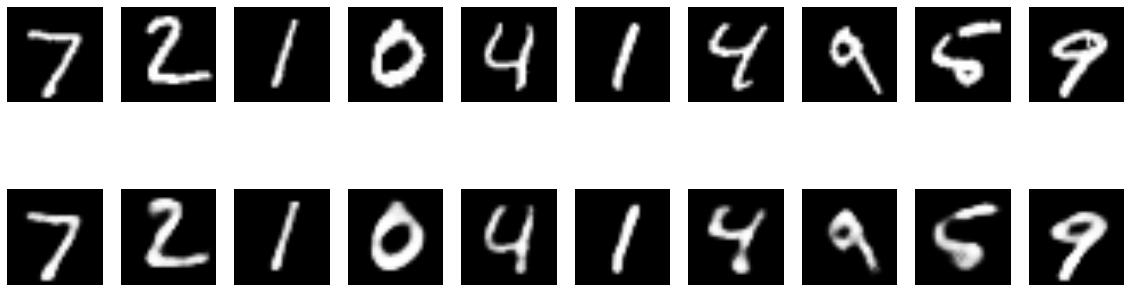

In [13]:
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display encoded
    #ax = plt.subplot(2, n, i + 1 + n)
    #plt.imshow(encoded_imgs[i].reshape(6, 6))
    #plt.gray()
    #ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)
   
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [14]:
#Predict the digits using a classifier
#Use the reduce Encoded train and test images
encoded_train_imgs = encoder.predict(x_train)
print (encoded_train_imgs.size)
print (encoded_train_imgs.shape)
print (encoded_train_imgs.nbytes)


2400000
(60000, 40)
19200000


In [15]:
encoded_test_imgs = encoder.predict(x_test)
print (encoded_test_imgs.size)
print (encoded_test_imgs.shape)
print (encoded_test_imgs.nbytes)

400000
(10000, 40)
3200000


In [16]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier()
clf = clf.fit(encoded_train_imgs, y_train)

In [17]:
y_pred = clf.predict(encoded_test_imgs)


In [18]:
num=len(encoded_test_imgs)
r=0
w=0
for i in range(num):
        #print ('y_pred ',y_pred[i])
        #print ('labels ',labels[i])
        #without the use of all() returns error truth value of an array with more than one element is ambiguous
        #if y_pred[i].all() == labels[i].all():
        if np.array_equal(y_pred[i],y_test[i]):
            r+=1
        else:
            w+=1
print ("tested ",  num, "digits")
print ("correct: ", r, "wrong: ", w, "error rate: ", float(w)*100/(r+w), "%")
print ("got correctly ", float(r)*100/(r+w), "%")


tested  10000 digits
correct:  9568 wrong:  432 error rate:  4.32 %
got correctly  95.68 %
